### Data Description
Pulse Transit Time PPG Dataset  
(https://www.physionet.org/content/pulse-transit-time-ppg/1.1.0/#files)  

다중 센서를 통한 PPG, ECG 등 데이터를 포함.  
22명의 피실험자 대상으로 3가지 활동을 수행하도록 함. (sit, walk, run)


In [236]:
import pandas as pd

ppg = pd.read_csv('./dataset/s9_sit.csv')
ppg

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 11:53:53.793086,30259,0,67562,81029,4548,72704,100328,4386,6490394,6484197,28.38,31.25,30.270075,5.387827,2.786394,-7.666026,-0.031880,-0.003963,-0.008745
1,2021-01-01 11:53:53.795086,29614,0,67562,81029,4548,72704,100328,4386,6488845,6484192,28.38,31.25,30.264084,5.392017,2.787591,-7.667822,-0.030016,-0.004495,-0.008478
2,2021-01-01 11:53:53.797086,29126,0,67572,81036,4544,72701,100333,4390,6488845,6484192,28.38,31.25,30.264084,5.377651,2.780408,-7.661237,-0.027486,-0.004629,-0.008079
3,2021-01-01 11:53:53.799086,28984,0,67580,81030,4546,72714,100339,4386,6488845,6484192,28.38,31.25,30.261089,5.365679,2.782204,-7.654054,-0.025754,-0.004629,-0.007813
4,2021-01-01 11:53:53.801086,29217,0,67576,81015,4547,72715,100331,4392,6488845,6484192,28.38,31.25,30.261089,5.360292,2.779211,-7.652857,-0.023224,-0.004762,-0.006880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243412,2021-01-01 12:02:00.617088,29653,0,67477,80152,4101,73240,99936,4274,6558846,6530600,28.50,31.38,30.434811,5.302828,2.111195,-7.917430,0.012196,0.003095,0.016955
243413,2021-01-01 12:02:00.619088,29493,0,67474,80158,4112,73234,99927,4279,6558846,6530600,28.50,31.38,30.443794,5.308814,2.109998,-7.909050,0.012329,0.002695,0.017088
243414,2021-01-01 12:02:00.621088,29494,0,67478,80155,4108,73230,99944,4277,6560521,6531056,28.50,31.38,30.449787,5.304026,2.106406,-7.897677,0.012995,0.003095,0.017222
243415,2021-01-01 12:02:00.623088,29588,0,67472,80159,4107,73237,99948,4283,6560521,6531056,28.50,31.38,30.452782,5.305821,2.102815,-7.894085,0.013927,0.003627,0.017222


데이터 일부를 취해 heartpy 분석이 가능한지 테스트

In [237]:
import heartpy as hp
import matplotlib.pyplot as plt

sample_rate = 500

data = (ppg.iloc[0:12000, [1]]).to_numpy().flatten()
data

array([30259, 29614, 29126, ..., 33360, 33208, 33080])

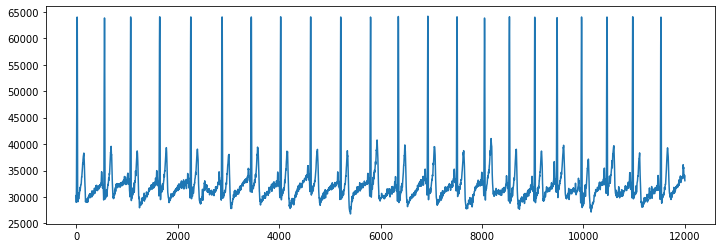

In [238]:
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

In [239]:
import matplotlib.pyplot as plt
import numpy as np

In [240]:
wd, m = hp.process(data, sample_rate)

# plt.figure(figsize=(12, 4))
# hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

bpm: 54.699608
ibi: 1096.900000
sdnn: 95.086224
sdsd: 40.384029
rmssd: 68.106727
pnn20: 0.631579
pnn50: 0.526316
hr_mad: 57.000000
sd1: 48.071161
sd2: 128.420578
s: 19394.076694
sd1/sd2: 0.374326
breathingrate: 0.182332


# 데이터 전처리  
파형 특성을 담은 dataframe 만들기

In [241]:
feature_df = pd.DataFrame(columns=['subject', 'bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate'])
feature_df

,subject,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate


각 피실험자의 데이터를 분할해 heartpy로 분석하고 dataframe에 파형의 특성들을 담기  
해당 과정을 반복

In [242]:
for subject_num in range(20):
    ppg = pd.read_csv('./dataset/s' + str(subject_num+1) + '_sit.csv')
    for i in range(20): # 25초 * 20 == 500초
        start_idx = i * 12000
        data = (ppg.iloc[start_idx:start_idx+12000, [1]]).to_numpy().flatten()
        new_features_list = []

        wd, m = hp.process(data, sample_rate)

        new_features_list.append(subject_num)
        for measure in m.keys():
            # print('%s: %f' %(measure, m[measure]))
            new_features_list.append(m[measure])
        
        feature_df.loc[len(feature_df)] = new_features_list

feature_df.to_csv('./dataset/processed/feature_data.csv', encoding='utf-8', mode='w', index=False)
feature_df

/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-

,subject,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,0.0,75.097108,798.965517,37.650372,18.155086,32.952347,0.607143,0.142857,30.0,23.299459,48.468036,3547.734683,0.480718,0.258956
1,0.0,73.285640,818.714286,31.992027,11.805,28.352281,0.592593,0.000000,19.0,20.030566,41.247289,2595.604452,0.485621,0.130867
2,0.0,74.666667,803.571429,21.443328,12.46427,24.899799,0.444444,0.037037,15.0,17.602999,24.513819,1355.649756,0.718085,0.266667
3,0.0,78.104660,768.200000,38.923343,15.936258,26.334716,0.448276,0.068966,27.0,18.621201,51.923661,3037.545949,0.358626,0.216957
4,0.0,72.345190,829.357143,36.578892,17.345991,32.874622,0.666667,0.037037,26.0,23.245337,46.951745,3428.762906,0.495090,0.086125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,19.0,81.952767,732.129032,53.373753,21.786438,33.819127,0.533333,0.133333,24.0,23.756917,71.162475,5311.179710,0.333841,0.264364
396,19.0,87.001024,689.647059,28.509939,16.493313,26.158028,0.393939,0.060606,25.0,18.478588,35.881859,2083.020735,0.514984,0.170590
397,19.0,83.912528,715.030303,50.498416,17.821599,29.593074,0.468750,0.093750,46.0,20.883419,68.739033,4509.775197,0.303807,0.127140
398,19.0,78.802206,761.400000,48.785654,20.946679,30.981641,0.379310,0.137931,34.0,21.776620,65.404731,4474.551418,0.332952,0.131337


In [243]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

feature_df = pd.read_csv('./dataset/processed/feature_data.csv')

# features
train_columns = ['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate']

# Scale X value
scaler = StandardScaler()
scaler.fit(feature_df[train_columns])

feature_scaled_X = scaler.transform(feature_df[train_columns])
feature_scaled_X_df = pd.DataFrame(feature_scaled_X, columns=train_columns)

# (y value type) float to int
feature_df['subject'] = feature_df['subject'].astype(int)

# train / test 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(feature_scaled_X_df, feature_df['subject'],
                                                    test_size = 0.1, random_state = 32)

# normalize y value
le = LabelEncoder()
y_train = le.fit_transform(y_train)

X_train

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
288,93.151630,644.111111,80.594933,27.53230384660973,35.856858,0.342857,0.085714,55.0,25.321637,111.449449,8865.833630,0.227203,0.172503
44,75.077667,799.172414,55.416958,17.41143771390824,33.519717,0.642857,0.107143,40.0,23.692923,69.731171,5190.335981,0.339775,0.258889
361,75.619296,793.448276,85.532646,33.28602084469499,52.478567,0.678571,0.321429,46.0,36.674242,112.521427,12964.215582,0.325931,0.130378
60,77.045696,778.758621,35.759402,17.38093607305171,25.176520,0.285714,0.071429,24.0,17.724292,46.470393,2587.587861,0.381410,0.309954
34,113.822540,527.136364,23.262915,6.8705090056527105,9.562524,0.046512,0.000000,14.0,6.748194,31.889886,676.068083,0.211609,0.129344
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,74.175121,808.896552,63.010861,24.764503068805926,36.689820,0.500000,0.178571,54.0,25.860842,86.066820,6992.432675,0.300474,0.127888
310,121.806298,492.585366,217.155556,34.38205512015991,439.746161,1.000000,1.000000,68.0,310.862421,25.054846,24468.640201,12.407277,0.346603
389,83.391244,719.500000,69.117653,21.395633969706548,27.307095,0.258065,0.096774,24.0,18.857481,93.463499,5537.013460,0.201763,0.086866
43,68.880254,871.076923,30.042179,14.856325252228427,35.861958,0.800000,0.120000,23.0,25.349146,34.966224,2784.594341,0.724961,0.264924


In [244]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=300,
                      learning_rate=0.1, 
                      max_depth=3, 
                      random_state=32, 
                      objective='multi:softprob')
model.fit(X_train, y_train) # 모델 학습

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:sdsd

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy_score(y_pred, y_test)

feature의 중요도를 평가

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(model, ax=ax)

plot_tree 시각화

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 80, 80
plot_tree(model, num_trees=3)
plt.show()